In [45]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import os
import matplotlib as mpl
import math
import json
from torch.utils.data import DataLoader
from tqdm import tqdm
from crp.image import imgify, vis_opaque_img, plot_grid

In [3]:
from expbasics.leemann import disjoint_orthogonality_loss, nearest_neighbors, vis_nearest_neighbors
from expbasics.helper import get_attributions, get_model_etc, get_dr_methods, get_centroids, get_cavs
from expbasics.network import train_network, accuracy_per_class
from expbasics.biased_noisy_dataset import BiasedNoisyDataset
from expbasics.ground_truth_measures import GroundTruthMeasures
from expbasics.crp_attribution import CRPAttribution
from expbasics.visualizations import visualize_dr, data_iterations, ground_truth_plot
from torch.utils.data import Dataset, DataLoader, random_split

%reload_ext autoreload
%autoreload 2

In [6]:
BIAS = 0.8
BATCH_SIZE = 128
N_BASIS = 2
STRENGTH = 0.5
LR = 0.001

LAYER_NAME = "linear_layers.0"

model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(BIAS)
methods, names = get_dr_methods()

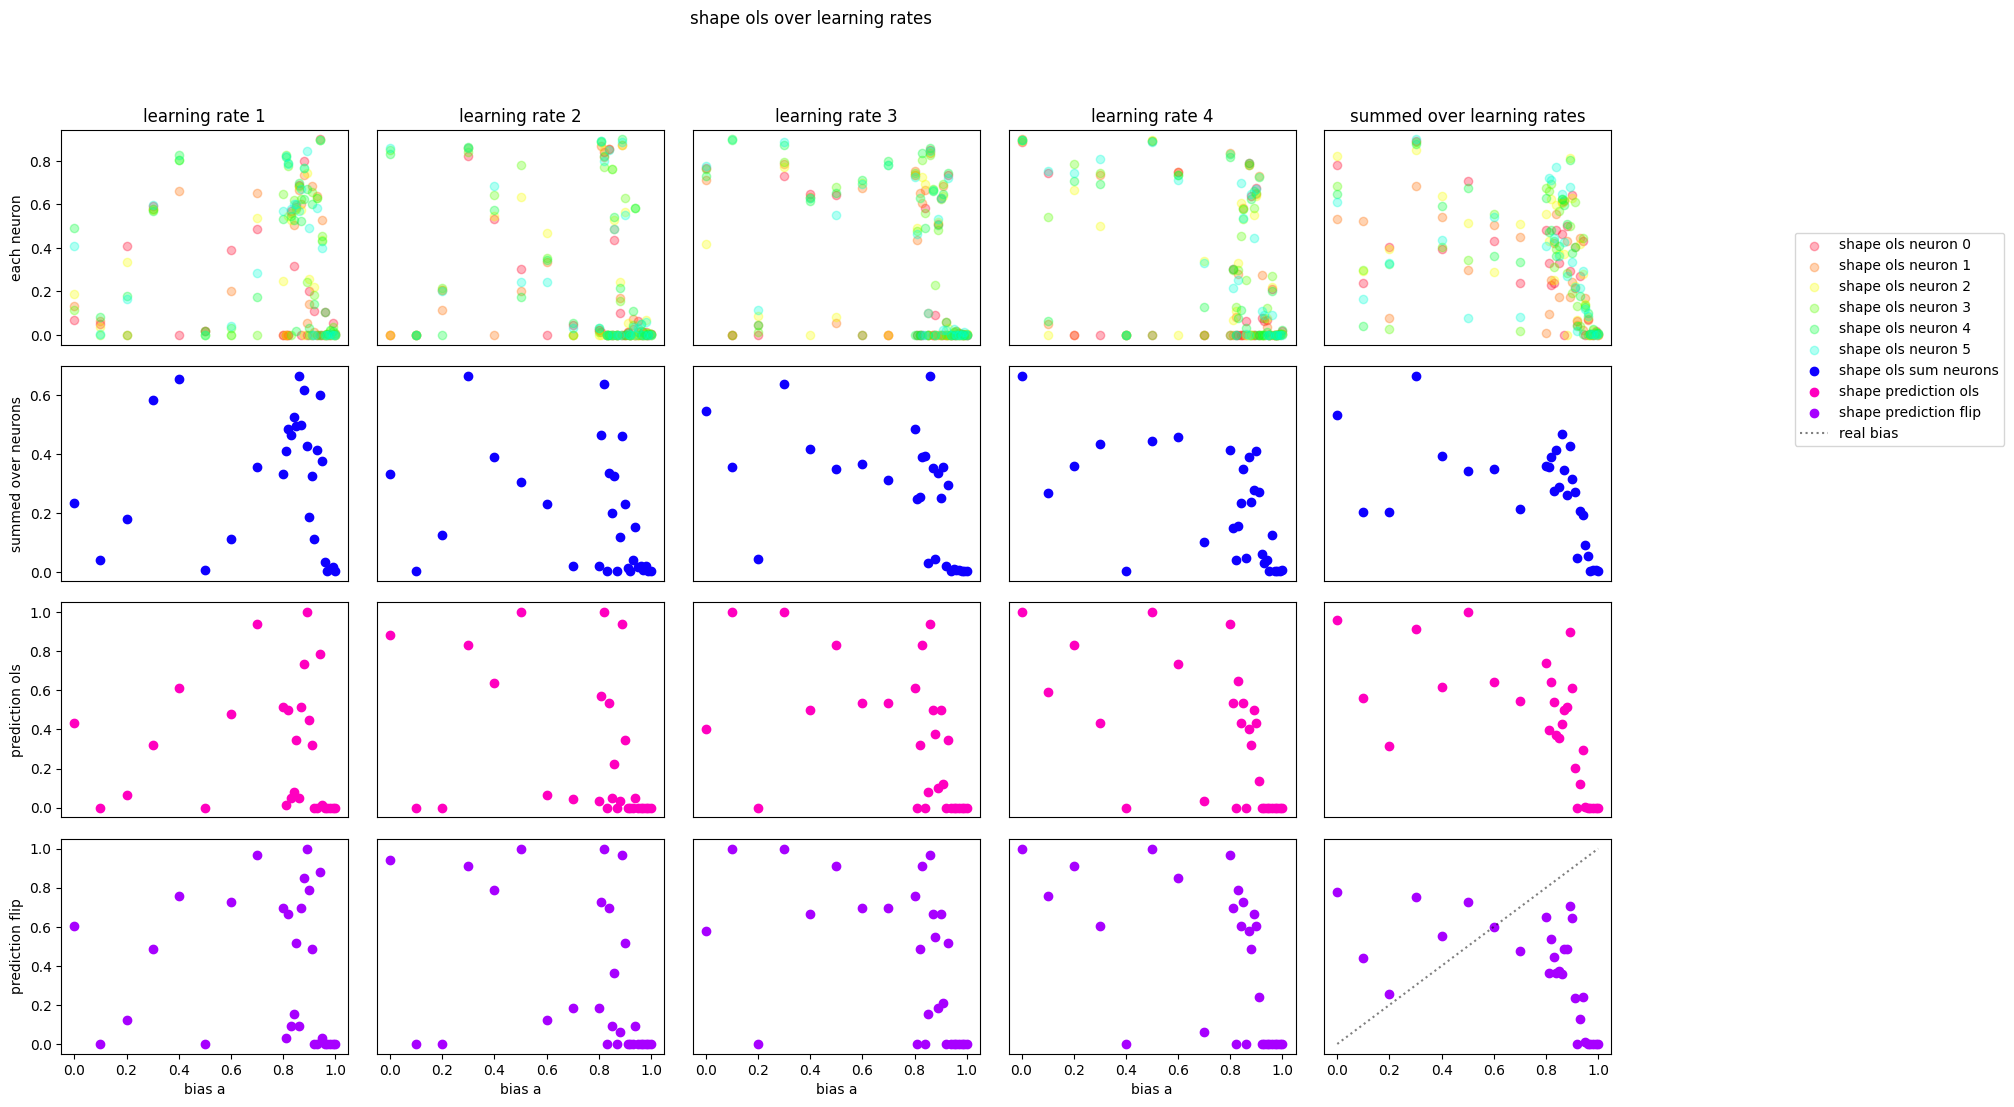

In [136]:
datas, filtbiases, biases = data_iterations("outputs/noisy_accuracies.json")

ground_truth_plot(datas, filtbiases, 1, m_type="ols")


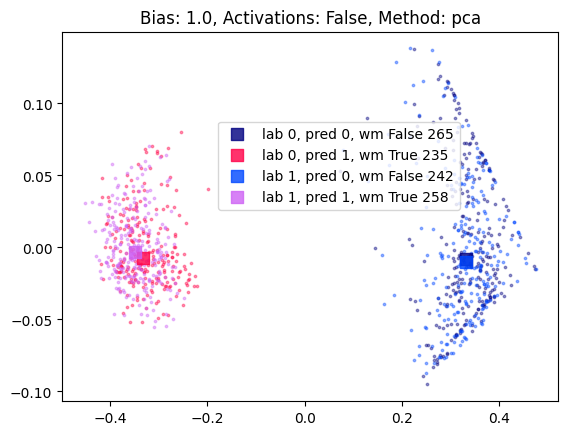

In [7]:
BIASES = filtbiases#np.round(np.linspace(0, 1, 11), 3)
ACTIVATIONS = False
METHOD = 0
all_centroids = {}
all_distances = {}

for bias in BIASES:
    for num_it in range(1):
        model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(bias, num_it=num_it)
        #idx, cavs = get_cavs(model, unbiased_ds, activations=ACTIVATIONS)
        #res = methods[METHOD].fit_transform(cavs.numpy())
        vector, watermarks, predictions, labels, idx = get_attributions(model, ACTIVATIONS, gm, crp_attribution)
        centroids = visualize_dr(
            methods, names, vector, watermarks, labels, predictions, bias, ACTIVATIONS, num_it
        )
        all_centroids[str(bias)] = centroids


In [52]:
concept_means = {}

for bias in tqdm(BIASES):
    for num_it in range(4):
        model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(bias, num_it=num_it)
        vector, watermarks, predictions, labels, idx = get_attributions(model, ACTIVATIONS, gm, crp_attribution)
        name = f"{bias}_{num_it}"
        concept_means[name] = {}
        for lab in [0, 1]:
            for wm in [0, 1]:
                for pred in [0, 1]:
                    d = np.logical_and(watermarks == wm, labels == lab)
                    d = np.logical_and(d, predictions == pred)
                    if vector[d].shape[0]> 0:
                        concept_means[name][f"l{lab}_w{wm}_p{pred}"] = torch.mean(vector[d], dim=0).tolist()

    with open("outputs/concept_means.json", "w") as f:
        json.dump(concept_means, f, indent=2)

100%|██████████| 29/29 [09:44<00:00, 20.16s/it]


In [71]:
concept_means_sums = {}
combis = [["l0_w0_p0", "l0_w1_p0"], ["l1_w0_p0", "l1_w1_p0"]]
for bias in tqdm(BIASES):
    sumname = str(bias)
    concept_means_sums[sumname] = {}
    for lab in [0, 1]:
        for wm in [0, 1]:
            for pred in [0, 1]:
                concept_means_sums[sumname][f"l{lab}_w{wm}_p{pred}"] = np.zeros(6)
                for num_it in range(4):
                    name = f"{bias}_{num_it}"
                    concept_means_sums[sumname][f"l{lab}_w{wm}_p{pred}"] += concept_means[name][f"l{lab}_w{wm}_p{pred}"] / 4


100%|██████████| 29/29 [00:00<00:00, 9459.12it/s]


In [107]:
concept_means_combis = {}
combis = [["l0_w0_p0", "l0_w1_p0"], ["l1_w0_p0", "l1_w1_p0"]]
for bias in tqdm(BIASES):
    sumname = str(bias)
    concept_means_combis[sumname] = {}
    for num_it in range(4):
        name = f"{bias}_{num_it}"
        for x, c in enumerate(combis):
            diff = np.linalg.norm((concept_means[name][c[0]]) - (concept_means[name][c[1]]))
            concept_means_combis[sumname][x] = diff
        
plt.scatter(BIASES, [a[0] for a in concept_means_combis.values()], label="rectangle")
plt.scatter(BIASES, [a[1] for a in concept_means_combis.values()], label="ellipse")
plt.title("Average Distance of Concept Means with and without watermark")
plt.legend()

100%|██████████| 29/29 [00:00<00:00, 23929.73it/s]


  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 19758.74it/s]


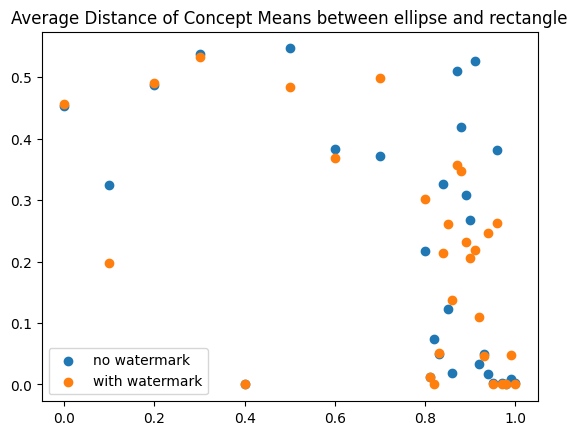

In [115]:
concept_means_combis = {}
combis = [["l0_w0_p0", "l1_w0_p0"], ["l0_w1_p0", "l1_w1_p0"]]
for bias in tqdm(BIASES):
    sumname = str(bias)
    concept_means_combis[sumname] = {}
    for num_it in range(4):
        name = f"{bias}_{num_it}"
        for x, c in enumerate(combis):
            diff = np.linalg.norm((concept_means[name][c[0]]) - (concept_means[name][c[1]]))
            concept_means_combis[sumname][x] = diff
        
plt.scatter(BIASES, [a[0] for a in concept_means_combis.values()], label="no watermark")
plt.scatter(BIASES, [a[1] for a in concept_means_combis.values()], label="with watermark")
plt.title("Average Distance of Concept Means between ellipse and rectangle")
plt.legend()

In [104]:
with open("outputs/concept_means.json", "r") as f:
    old_concept_means = json.load(f)

In [150]:
labels = []
for label in [0, 1]:
    for watermark in [0, 1]:
        for prediction in [0, 1]:
            labels.append(f"l{label}_w{watermark}_p{prediction}")

In [106]:

labels_no_pred = ["", "", "", ""]
for bias in tqdm(BIASES):
    for num_it in range(4):
        name = f"{bias}_{num_it}"
        for label in [0, 1]:
            for watermark in [0, 1]:
                for prediction in [0, 1]:
                    x = f"l{label}_w{watermark}_p{prediction}"
                    if x not in old_concept_means[name]:
                        """ if prediction == 1 and f"l{label}_w{watermark}_p{0}" in old_concept_means[name]:
                            print("here")
                            avge = np.array(old_concept_means[name][f"l{label}_w{watermark}_p{0}"])
                        elif prediction == 0 and f"l{label}_w{watermark}_p{1}" in old_concept_means[name]:
                            print("there")
                            avge = np.array(old_concept_means[name][f"l{label}_w{watermark}_p{1}"])
                        else:
                            print("noweher") """
                        avge = np.array(list(old_concept_means[name].values())).mean(axis=0)
                        concept_means[name][x] = avge
                    else:
                        concept_means[name][x] = np.array(old_concept_means[name][x])

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 7883.01it/s]


In [154]:
all_centroids = {f"{datas[i][a]['bias']}_{datas[i][a]['num_it']}": np.array(datas[i][a]["centroids"], dtype=np.float64) for a in range(len(datas[0]))  for i in range(4) }

for k,v in all_centroids.items():
    mval = np.mean(v[~np.isnan(v[:,0])], axis= 0)
    for c in range(8):
        if math.isnan(v[c,0]):
            all_centroids[k][c] = mval

In [161]:
reduced_concept_means = {}

for bias in tqdm(BIASES):
    for num_it in range(4):
        model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(
            bias, num_it=num_it
        )
        vector, watermarks, predictions, labels, idx = get_attributions(
            model, ACTIVATIONS, gm, crp_attribution
        )
        name = f"{bias}_{num_it}"
        reduced_concept_means[name] = {}
        for lab in [0, 1]:
            for wm in [0, 1]:
                d = np.logical_and(watermarks == wm, labels == lab)
                if vector[d].shape[0] > 0:
                    reduced_concept_means[name][f"l{lab}_w{wm}"] = torch.mean(
                        vector[d], dim=0
                    ).tolist()

    with open("outputs/reduced_concept_means.json", "w") as f:
        json.dump(reduced_concept_means, f, indent=2)

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [167]:
with open("outputs/reduced_concept_means.json", "r") as f:
    reduced_concept_means = json.load(f)
reduced_concept_means = {k:{c:np.array(v) for c,v in w.items()} for k,w in reduced_concept_means.items()}
reduced_concept_means

{'0.0_0': {'l0_w0': array([ 0.00191675, -0.29981738,  0.31796026, -0.16559342, -0.21284463,
          0.00186753]),
  'l0_w1': array([ 0.00110097, -0.28543514,  0.3205041 , -0.1835843 , -0.20766099,
          0.00171447]),
  'l1_w0': array([ 0.0308259 , -0.10159566,  0.6303165 , -0.09695603, -0.07988612,
          0.06041985]),
  'l1_w1': array([ 0.0342033 , -0.11243618,  0.6182577 , -0.0937115 , -0.08397838,
          0.05741288])},
 '0.0_1': {'l0_w0': array([ 0.        ,  0.        ,  0.        , -0.97058499,  0.0158153 ,
          0.01359979]),
  'l0_w1': array([ 0.        ,  0.        ,  0.        , -0.963642  ,  0.02042058,
          0.01593739]),
  'l1_w0': array([ 0.        ,  0.        ,  0.        , -0.13485385,  0.45819029,
          0.40695587]),
  'l1_w1': array([ 0.        ,  0.        ,  0.        , -0.13431454,  0.45772049,
          0.40796497])},
 '0.0_2': {'l0_w0': array([ 0.00399873,  0.00994771,  0.0122776 , -0.25906283, -0.69849837,
          0.01621479]),
  'l0_w1

116 116


Text(0.5, 1.0, 'Mean Euclidean Distance of PCA Centroids changing shape')

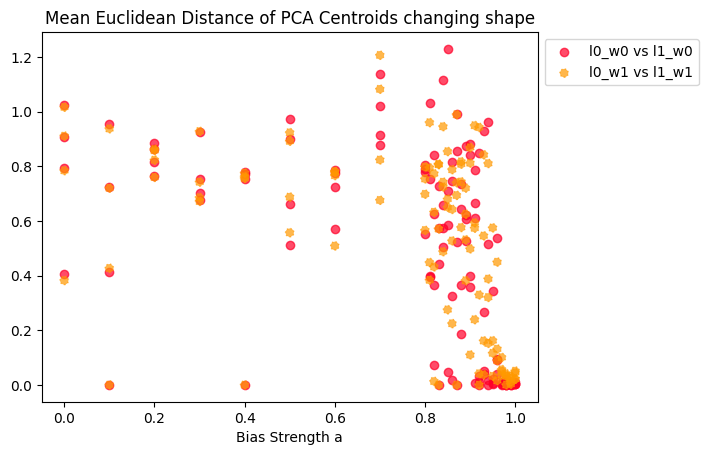

In [169]:
combis = [["l0_w0","l1_w0" ], ["l0_w1", "l1_w1"]]
colors = mpl.cm.gist_rainbow(np.linspace(0, 1, 8))  # gist_ncar
styles = ["solid", "dotted", "dashed", "dashdot"]
means = list(reduced_concept_means.values())
print(len(means), len(biases))
for x, c in enumerate(combis):
    diff = [np.linalg.norm((m[c[0]]) - (m[c[1]])) for m in means]
    plt.scatter(
        biases,
        diff,
        label=f"{c[0]} vs {c[1]}",
        color=colors[x],
        linestyle=styles[x % len(styles)],
        alpha=0.7,
    )


plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title("Mean Euclidean Distance of PCA Centroids changing shape")

In [ ]:
combis = [[0, 2], [5, 7]]
colors = mpl.cm.gist_rainbow(np.linspace(0, 1, 8))  # gist_ncar
styles = ["solid", "dotted", "dashed", "dashdot"]
means = list(all_centroids.values())
print(len(means), len(biases))
for x, c in enumerate(combis):
    diff = [np.linalg.norm((m[c[0]]) - (m[c[1]])) for m in means]
    plt.scatter(
        biases,
        diff,
        label=f"{labels[c[0]]} vs {labels[c[1]]}",
        color=colors[x],
        linestyle=styles[x % len(styles)],
        alpha=0.7,
    )


plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title("Mean Euclidean Distance of PCA Centroids changing watermark")

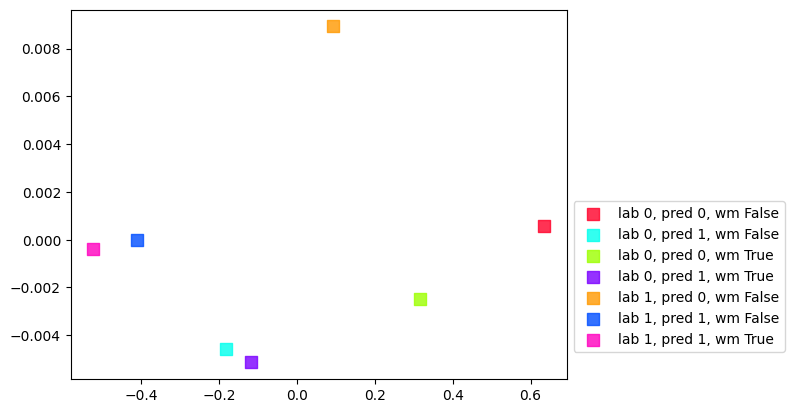

In [44]:
b = "0.94"

for lab in [0, 1]:
    for wm in [0, 1]:
        for pred in [0, 1]:
                if not math.isnan(all_centroids[b][lab + 2 * wm + 4 * pred, 0]):
                    plt.scatter(
                        all_centroids[b][lab + 2 * wm + 4 * pred, 0],
                        all_centroids[b][lab + 2 * wm + 4 * pred, 1],
                        color=colors[lab + 2 * wm + 4 * pred],
                        marker="s",  # type: ignore
                        s=70,
                        label=f"lab {lab}, pred {pred}, wm {wm == 1}",
                        alpha=0.8,
                    )
plt.legend(bbox_to_anchor=(1, 0.5))